### Data preprocessing

In [42]:
# Importing necessary modules
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import the dataset
drugs = pd.read_excel("/Users/kevintomas/Desktop/nf-sep-20/Personality-and-Drug-use/drug_consumption.xls")

In [3]:
#Renaming Personality trait columns
drugs=drugs.rename(columns={"Escore":"Extraversion", "Nscore":"Neuroticism", "Oscore":"Openness", 
                      "Ascore":"Agreeableness","Cscore":"Conscientiousness", "Impulsive":"Impulsiveness",
                     "SS":"Sensation_Seeking"})

In [4]:
#Renaming drug columns
drugs=drugs.rename(columns={"Amphet":"Amphetamines", "Amyl":"Amyl_Nitrite", "Coke":"Cocaine", 
                      "Legalh":"Legal_Highs","Caff":"Caffein", "Choc":"Chocolate",
                     "Shrooms":"Mushrooms"})

In [5]:
#Handle the semer columns
drugs = drugs[drugs['Semer'] == "CL0"]
drugs = drugs.drop("Semer", axis=1)

In [6]:
#tranforming the drugs columns
drugs_columns = [
    'Alcohol',
    'Amphetamines',
    'Amyl_Nitrite',
    'Benzos',
    'Caffein',
    'Cannabis',
    'Chocolate',
    'Cocaine',
    'Crack',
    'Ecstasy',
    'Heroin',
    'Ketamine',
    'Legal_Highs',
    'LSD',
    'Meth',
    'Mushrooms',
    'Nicotine',
    'VSA'
]
# Changing staments concerning drug usage into integers
for i in drugs_columns:
    drugs[i] = drugs[i].apply(lambda x: int(x[-1]))

***An dieser Stelle könnte man yearly, monthly, weekly, daily user unterscheiden***

In [7]:
#splitting users from non-users
for i in drugs_columns:
    drugs[i] = drugs[i].apply(lambda x: 0 if x <3 else 1)

In [8]:
#dropping chocolate and caffein
drugs = drugs.drop("Chocolate", axis=1)
drugs = drugs.drop("Caffein", axis=1)

In [9]:
#splitting legal from illegal drugs
df_temp = drugs

df_temp = df_temp.drop("Alcohol", axis=1)

df_temp = df_temp.drop("Nicotine", axis=1)

#df_temp = df_temp.drop("legal_drugs", axis=1)

In [10]:
df_temp["illegal_drugs"] = df_temp.iloc[:, 13:].sum(axis=1)

In [11]:
df_temp["illegal_drugs"] = df_temp["illegal_drugs"].apply(lambda x: 0 if x<1 else 1)

In [12]:
drugs = pd.concat([df_temp["illegal_drugs"], drugs], axis=1)

In [13]:
drugs = drugs.drop("Alcohol", axis=1)

In [14]:
#converting the countries
country = ['USA' if c < -0.5 else 
           'New Zealand' if c > -0.5 and c < -0.4 else 
           'Other' if c > -0.4 and c < -0.2 else 
           'Australia' if c > -0.2 and c < 0 else 
           'Ireland' if c > 0 and c < 0.23 else 
           'Canada' if c > 0.23 and c < 0.9 else 
           'UK' 
           for c in drugs['Country']]

In [15]:
drugs['Country'] = country

In [16]:
#take only the data from the UK
drugs_uk = drugs.query("Country == 'UK'")

In [17]:
#converting the age column
warnings.filterwarnings('ignore')

age = ['18-24' if a <= -0.9 else 
       '25-34' if a >= -0.5 and a < 0 else 
       '35-44' if a > 0 and a < 1 else 
       '45-54' if a > 1 and a < 1.5 else 
       '55-64' if a > 1.5 and a < 2 else 
       '65+' 
       for a in drugs_uk['Age']]

drugs_uk["Age"] = age

In [18]:
#drop the 65+
drugs_uk = drugs_uk.query("Age != '65+'")

In [19]:
# women == 1 and men == 0
drugs_uk.Gender = drugs_uk.Gender.apply(lambda x: 1 if x > 0 else 0)

In [20]:
#drop columns we dont need
drugs_uk = drugs_uk.drop(["ID", "Age","Education", "Country", "Ethnicity"], axis=1)

In [26]:
drugs_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 0 to 1850
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   illegal_drugs      1032 non-null   int64  
 1   Gender             1032 non-null   int64  
 2   Neuroticism        1032 non-null   float64
 3   Extraversion       1032 non-null   float64
 4   Openness           1032 non-null   float64
 5   Agreeableness      1032 non-null   float64
 6   Conscientiousness  1032 non-null   float64
 7   Impulsiveness      1032 non-null   float64
 8   Sensation_Seeking  1032 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 80.6 KB


## Building the model

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, make_scorer, fbeta_score, plot_confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score

***Generally:*** 
* Target value is ```illegal drugs```. If we would include all drugs, the target value would be highly inbalanced. The **balance** of the target is following: **61% (non-users) vs. 39 (user)**

* Only the **UK data** is used. The balance of the target value differs significantly from country to country, so a generalization from other countries to UK are diffcult
* ```ID```, ```Age``` and ```Education``` are dropped, because we are predicting the drug use for school students and therefore these columns would not make sense to be included
* ```Country``` can also be dropped due to the fact, that our scenario plays in the UK
* ```Ethnicity``` is also dropped
* All of the ```drug columns``` can be dropped, beacuse the target value is the subject of interest and the target arises from these columns
* So the **focus** of the model really lies on **the personaltiy traits** and less on the demografics


***Result:***
* Columns included: ```Gender```, ```Nscore```, ```Escore```, ```Oscore```, ```Ascore```, ```Cscore```, ```Impulsive```, ```SS``` and the **target** ```illegal_drugs```

### Splitting the data

In [28]:
y = np.array(drugs_uk.pop('illegal_drugs'))
X = drugs_uk.iloc[:, 0:]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=25)

## LogReg

In [47]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       123
           1       0.68      0.50      0.58        84

    accuracy                           0.70       207
   macro avg       0.69      0.67      0.67       207
weighted avg       0.70      0.70      0.69       207



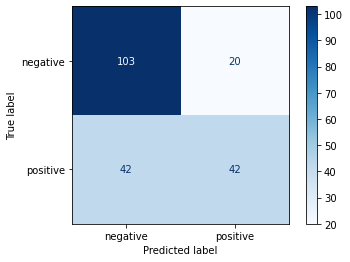

In [46]:
disp = plot_confusion_matrix(LogReg, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

### Changed the threshold to 0.4

In [48]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

y_pred_tuned = (LogReg.predict_proba(X_test) >= 0.4)[:,1]

In [49]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       123
           1       0.60      0.69      0.64        84

    accuracy                           0.69       207
   macro avg       0.68      0.69      0.69       207
weighted avg       0.70      0.69      0.69       207



In [50]:
print(confusion_matrix(y_test, y_pred_tuned))

[[85 38]
 [26 58]]


In [54]:
coefficients = pd.Series(LogReg.coef_[0], X_train.columns)
coefficients

Gender              -0.500765
Neuroticism          0.152833
Extraversion        -0.133926
Openness             0.475577
Agreeableness       -0.103386
Conscientiousness   -0.392342
Impulsiveness        0.056900
Sensation_Seeking    0.742965
dtype: float64

## Decision Tree

In [71]:
# Creating the classifier object 
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            max_depth=7, min_samples_leaf=5) 

# Performing training 
clf_gini.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

In [72]:
y_pred = clf_gini.predict(X_test) 

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       123
           1       0.62      0.54      0.57        84

    accuracy                           0.68       207
   macro avg       0.66      0.65      0.66       207
weighted avg       0.67      0.68      0.67       207



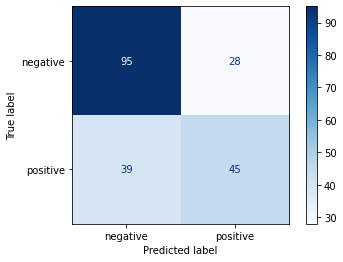

In [74]:
disp = plot_confusion_matrix(clf_gini, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

***Change the threshold to 0.4***

In [75]:
y_pred_tuned = (clf_gini.predict_proba(X_test) >= 0.4)[:,1]
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       123
           1       0.59      0.61      0.60        84

    accuracy                           0.67       207
   macro avg       0.66      0.66      0.66       207
weighted avg       0.67      0.67      0.67       207



In [76]:
print(confusion_matrix(y_test, y_pred_tuned))

[[88 35]
 [33 51]]
